## ImageMagick processing

remove white borders and save as .png
http://www.imagemagick.org/Usage/masking/#bg_remove

In [21]:
import subprocess
import os

raw_path = os.path.join('data', 'raw')
processed_path = os.path.join('data', 'processed')

subfolders = [ f.path for f in os.scandir(raw_path) if f.is_dir() ]

for subfolder in subfolders:
    folder = os.path.basename(subfolder)
    indir = os.path.join(raw_path, folder)
    outdir = os.path.join(processed_path, folder)
    
    files = os.listdir(indir)
    for file in files:
        # set input and output file names
        infile = os.path.join(indir, file)
        outfile = os.path.join(processed_path, folder, file[:file.rindex('.')] + '.png')

        # call ImageMagick via shell command
        cmd = f'convert {infile} {outfile}'
        os.system(cmd)

## Superimpose boxes on backgrounds

In [22]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches
import numpy as np
%matplotlib inline
from PIL import Image, ImageFilter
import os

### Image processing functions

In [83]:
def resize_image(fg_image, bg_image):
    """Resize foreground image to be have a height that is between 20%
    and 50% the height of the background image""" 
    fg_height = fg_image.size[1]
    bg_height = bg_image.size[1]
    
    rand = np.random.uniform(0.2*bg_height/fg_height, 0.5*bg_height/fg_height)
    r1 = int(rand*fg_image.size[0])
    r2 = int(rand*fg_image.size[1])
    return fg_image.resize((r1,r2))


def tweak_color(image):
    """Tweak color by a small and random amount."""
    px = np.array(image)
    px[:,:,0] = px[:,:,0]*np.random.uniform(0.6,1)
    px[:,:,1] = px[:,:,1]*np.random.uniform(0.6,1)
    px[:,:,2] = px[:,:,2]*np.random.uniform(0.6,1)
    return Image.fromarray(px)

def blur(image):
    """Blue image by random amount. Determine blur magnitude using
    pareto distribution so that large blurs are rare"""
    blur_rad = np.min([np.random.pareto(2), 2])
    return image.filter(ImageFilter.GaussianBlur(radius=blur_rad))

def make_perspective_coeffs(pa,pb):
    """Determines coefficients to be used in nonlinear perpective transformation"""
    matrix = []
    for p1,p2 in zip(pa,pb):
        matrix.append([p1[0],p1[1],1,0,0,0,-p2[0]*p1[0],-p2[0]*p1[1]])
        matrix.append([0,0,0,p1[0],p1[1],1,-p2[1]*p1[0],-p2[1]*p1[1]])

    A = np.matrix(matrix,dtype=np.float)
    B = np.array(pb).reshape(8)

    res = np.dot(np.linalg.inv(A.T*A)*A.T,B)
    return np.array(res).reshape(8)

def perspective_transformation(image):
    width = image.size[0]
    height = image.size[1]

    r = np.random.uniform()
    if r < 0.5:
        width_shift = width*np.random.uniform(0.0,0.2)
        height_shift = 0
    else:
        width_shift = 0
        height_shift = height*np.random.uniform(0.0,0.2)
    #print((width_shift,height_shift))
    r = np.random.uniform()
    if r < 0.5:
        coeffs = make_perspective_coeffs([(0,0), (width,height_shift), (width_shift,height), (width-width_shift,height-height_shift)],
            [(0,0), (width,0), (0,height), (width,height)])
    else:
        coeffs = make_perspective_coeffs([(width_shift,height_shift), (width-width_shift,0), (0,height-height_shift), (width,height)],
            [(0,0), (width,0), (0,height), (width,height)])

    return image.transform((width,height),Image.PERSPECTIVE,coeffs,Image.BICUBIC)

def full_processing_routine(image, bg_image):
    image = resize_image(image, bg_image)
    image = tweak_color(image)
    image = blur(image)
    #image = perspective_transformation(image)
    
    # crop to alpha
    #return image.crop(image.getbbox())
    return image
    

### Generate labeled data

In [196]:
# choose background image
bg_dir_path = os.path.join('data', 'processed', 'shelves')
bg_files = os.listdir(bg_dir_path)
bg_fname = bg_files[np.random.randint(0, len(bg_files))]
bg_img = Image.open(os.path.join(bg_dir_path, bg_fname))
bg_img = Image.open(os.path.join(bg_dir_path, '6014025_031420-kfsn-6p-local-business-coronavirus-vid.png'))

3 channels


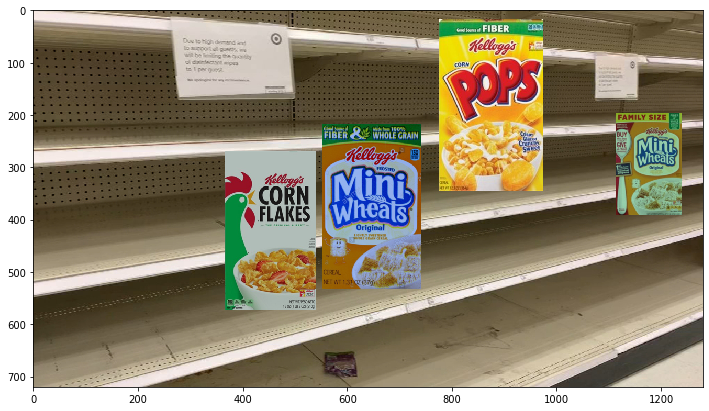

In [200]:
fg_dirs = [ f.path for f in os.scandir(os.path.join('data', 'processed')) if f.is_dir()]
fg_dirs = [fg_dir for fg_dir in fg_dirs if 'shelves' not in fg_dir]

for i in np.arange(0,1):
    fg_dir_path = fg_dirs[np.random.randint(0,len(fg_dirs))]
    fg_files = os.listdir(fg_dir_path)
    fg_img = fg_files[np.random.randint(0, len(fg_files))]
    
    fg_img = Image.open(os.path.join(fg_dir_path, fg_img))

    # process foreground image
    fg_img = full_processing_routine(fg_img, bg_img)
    
    # set fg image location
    xpos = int(np.floor(np.random.uniform(0, bg_img.size[0]-fg_img.size[0])))
    ypos = int(np.floor(np.random.uniform(0, bg_img.size[1]-fg_img.size[1])))
    
    # define label
    label = [xpos, ypos, bg_img.size[0]-fg_img.size[0], bg_img.size[1]-fg_img.size[1]]
    
    # superimpose
    if len(fg_img.getbands()) == 4:
        print('4 channels')
        bg_img.paste(fg_img, (xpos,ypos), fg_img) # what to paste, coords, mask where if transparent then alpha channel is mask
    elif len(fg_img.getbands()) == 3:
        print('3 channels')
        bg_img.paste(fg_img, (xpos,ypos))
        
    
    
fig, ax = plt.subplots(1, figsize=(12,12))
ax.imshow(np.array(bg_img))
#rect = patches.Rectangle((xpos,ypos), fg_img.size[0], fg_img.size[1], linewidth=2, edgecolor='r',facecolor='none')
#ax.add_patch(rect);


In [94]:
# Load images
box_path = os.path.join('img', 'Froot_Loops', 'b.png')
fg_img = Image.open(box_path)

# process box image
fg_img = full_processing_routine(fg_img, bg_img)

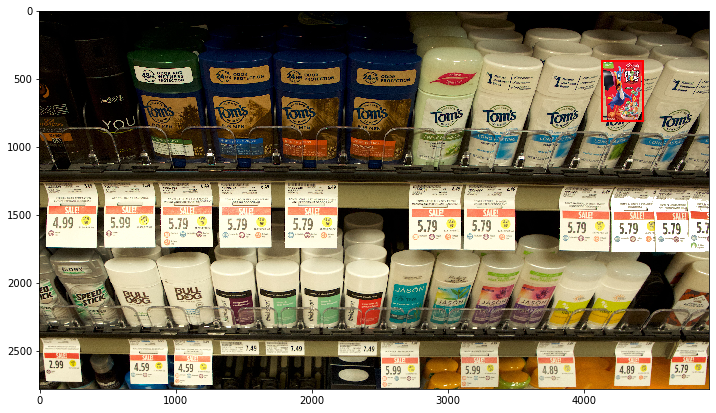

In [117]:
# set box location
xpos = int(np.floor(np.random.uniform(0, bg_img.size[0]-box.size[0])))
ypos = int(np.floor(np.random.uniform(0, bg_img.size[1]-box.size[1])))

# define label
label = [xpos, ypos, bg_img.size[0]-fg_img.size[0], bg_img.size[1]-fg_img.size[1]]

# superimpose
bg_img.paste(fg_img, (xpos,ypos), fg_img) # what to paste, coords, mask where if transparent then alpha channel is mask

fig, ax = plt.subplots(1, figsize=(12,12))
ax.imshow(np.array(bg_img))
rect = patches.Rectangle((xpos,ypos), fg_img.size[0], box.size[1], linewidth=2, edgecolor='r',facecolor='none')
ax.add_patch(rect);